In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
import random
from torch import nn

# Constants
SEED = 123
IMG_SIZE = 224
BATCH_SIZE = 64
LEARNING_RATE = 3e-5
EPOCHS = 1000
NUM_CLASSES = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label
    
def create_transforms():
    # Create transform pipeline manually
    train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
        transforms.RandomResizedCrop(
            size=IMG_SIZE,  # Output size
            scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.1)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]) 

    # Create transform pipeline manually
    test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return train_transforms, test_transforms

def load_and_split_data(data_path):
    data = pd.read_csv(data_path)
    data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=SEED)
    data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=SEED)
    return data_train, data_val, data_test

def create_datasets(data_train, data_val, data_test, train_transforms, test_transforms):
    train_dataset = FERDataset(data_train, transform=train_transforms)
    val_dataset = FERDataset(data_val, transform=test_transforms)
    test_dataset = FERDataset(data_test, transform=test_transforms)
    return train_dataset, val_dataset, test_dataset

def create_dataloaders(train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             generator=torch.Generator().manual_seed(SEED))
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                           generator=torch.Generator().manual_seed(SEED))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                            generator=torch.Generator().manual_seed(SEED))
    return train_loader, val_loader, test_loader

class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x
    
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output
    
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0., # Dropout for attention projection
                 mlp_dropout:float=0., # Dropout for dense/MLP layers 
                 embedding_dropout:float=0., # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
         
        self.num_patches = (img_size * img_size) // patch_size**2
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None):
        
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = torch.cat((class_token, x), dim=1)  # Shape: (batch_size, num_patches + 1, embedding_dim)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.norm(x)
        
        cls_token_final = x[:, 0]

        logits = self.head(cls_token_final)

        return logits

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1

        if self.epochs_no_improve >= self.patience:
            self.early_stop = True

        return self.early_stop
    
    
def train_model(model, train_loader, val_loader):
    # Initialize training utilities
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    early_stopping = EarlyStopping(patience=10, min_delta=0)

    # Define path
    SAVE_PATH = "E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix"
    os.makedirs(SAVE_PATH, exist_ok=True)

    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Initialize the best metric for model saving
    best_val_accuracy = -float('inf')

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Training
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{train_loss / (batch_idx + 1):.4f}",
                "Acc": f"{correct / total:.4f}"
            })

        # Calculate training accuracy and loss
        train_accuracy = correct / total
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Print training summary
        print(f"Epoch {epoch + 1}/{EPOCHS}: "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_targets = []
        all_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions for F1-score
                all_targets.extend(targets.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{val_correct / val_total:.4f}"
                })

        # Calculate validation accuracy, loss, and F1-score
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_targets, all_predicted, average="weighted")
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print validation summary
        print(f"Epoch {epoch + 1}/{EPOCHS}: "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}, "
              f"Val F1: {val_f1:.4f}")

        # Step the learning rate scheduler based on validation loss
        scheduler.step(avg_val_loss)

        # Print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model_path = os.path.join(SAVE_PATH, "vit_scratch_wAugment_best.pt")
            torch.save({
                "model_state_dict": model.state_dict()
            }, model_path)
    #         torch.save(model.state_dict(), model_path)
            print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

        # Save loss and accuracy plots
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        loss_plot_path = os.path.join(SAVE_PATH, "vit_scratch_wAugment_loss.png")
        plt.savefig(loss_plot_path)
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        accuracy_plot_path = os.path.join(SAVE_PATH, "vit_scratch_wAugment_accuracy.png")
        plt.savefig(accuracy_plot_path)
        plt.close()
        
        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}!")
            break

def evaluate_model(best_model, test_loader):
    criterion = nn.CrossEntropyLoss()
    best_model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(test_loader, desc="Testing")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = best_model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                "Acc": f"{test_correct / test_total:.4f}"
            })

    # Calculate test accuracy, loss, and F1-score
    test_accuracy = test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(all_targets, all_predicted, average="weighted")

    # Calculate per-class accuracy
    conf_matrix = confusion_matrix(all_targets, all_predicted)
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # Calculate classification report (includes precision, recall, F1-score, and support)
    class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

    # Print test summary
    print(f"Test Loss: {avg_test_loss:.4f}, "
          f"Test Acc: {test_accuracy:.4f},"
          f"Test F1: {test_f1:.4f}")

    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"Class {i}: {acc:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(class_report)
    
    normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
    emotion_dict = {
        0: "Angry", 1: "Disgust", 2: "Fear",
        3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprise"
    }
    emotion_labels = [emotion_dict[i] for i in range(len(emotion_dict))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=emotion_labels,
                yticklabels=emotion_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {DEVICE}")
    print(f"PyTorch version: {torch.__version__}")

    # Data preparation
    train_transforms, test_transforms = create_transforms()
    data_train, data_val, data_test = load_and_split_data("E://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013v2_clean.csv")
    train_dataset, val_dataset, test_dataset = create_datasets(data_train, data_val, data_test, train_transforms, test_transforms)
    
    train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    model = ViT(num_classes=len(class_names), 
                in_channels=3, 
                patch_size=32, 
                num_heads=12, 
                embedding_dim=768, 
                num_transformer_layers=12,
                mlp_size=3072)
    model.to(DEVICE)
    
    train_model(model, train_loader, val_loader)
    
    best_model = ViT(num_classes=len(class_names), 
                     in_channels=3, 
                     patch_size=32, 
                     num_heads=12, 
                     embedding_dim=768, 
                     num_transformer_layers=12,
                     mlp_size=3072)
    best_model = best_model.to(DEVICE)
    
    checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix//vit_scratch_wAugment_best.pt")
    best_model.load_state_dict(checkpoint["model_state_dict"])
    
    evaluate_model(best_model, test_loader)

if __name__ == "__main__":
    main()

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Using device: cuda
PyTorch version: 2.5.0+cu124


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [04:30<00:00,  1.56it/s, Loss=1.7755, Acc=0.2674]


Epoch 1/1000: Train Loss: 1.7755, Train Acc: 0.2674


Epoch 1/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:09<00:00,  4.72it/s, Loss=1.7010, Acc=0.3125]


Epoch 1/1000: Val Loss: 1.7010, Val Acc: 0.3125, Val F1: 0.2022
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.3125


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [05:17<00:00,  1.33it/s, Loss=1.6777, Acc=0.3319]


Epoch 2/1000: Train Loss: 1.6777, Train Acc: 0.3319


Epoch 2/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:10<00:00,  4.52it/s, Loss=1.5970, Acc=0.3722]


Epoch 2/1000: Val Loss: 1.5970, Val Acc: 0.3722, Val F1: 0.3313
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.3722


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [05:34<00:00,  1.26it/s, Loss=1.6313, Acc=0.3546]


Epoch 3/1000: Train Loss: 1.6313, Train Acc: 0.3546


Epoch 3/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:11<00:00,  3.92it/s, Loss=1.5697, Acc=0.3866]


Epoch 3/1000: Val Loss: 1.5697, Val Acc: 0.3866, Val F1: 0.3271
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.3866


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [05:40<00:00,  1.24it/s, Loss=1.6009, Acc=0.3725]


Epoch 4/1000: Train Loss: 1.6009, Train Acc: 0.3725


Epoch 4/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.91it/s, Loss=1.5111, Acc=0.4113]


Epoch 4/1000: Val Loss: 1.5111, Val Acc: 0.4113, Val F1: 0.3689
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4113


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [05:39<00:00,  1.24it/s, Loss=1.5672, Acc=0.3838]


Epoch 5/1000: Train Loss: 1.5672, Train Acc: 0.3838


Epoch 5/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.63it/s, Loss=1.5343, Acc=0.4053]


Epoch 5/1000: Val Loss: 1.5343, Val Acc: 0.4053, Val F1: 0.3925
Current Learning Rate: 3e-05


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [05:50<00:00,  1.21it/s, Loss=1.5382, Acc=0.3982]


Epoch 6/1000: Train Loss: 1.5382, Train Acc: 0.3982


Epoch 6/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.79it/s, Loss=1.4550, Acc=0.4420]


Epoch 6/1000: Val Loss: 1.4550, Val Acc: 0.4420, Val F1: 0.4114
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4420


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [05:48<00:00,  1.21it/s, Loss=1.5169, Acc=0.4079]


Epoch 7/1000: Train Loss: 1.5169, Train Acc: 0.4079


Epoch 7/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.91it/s, Loss=1.4712, Acc=0.4416]


Epoch 7/1000: Val Loss: 1.4712, Val Acc: 0.4416, Val F1: 0.4063
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [05:48<00:00,  1.21it/s, Loss=1.4966, Acc=0.4165]


Epoch 8/1000: Train Loss: 1.4966, Train Acc: 0.4165


Epoch 8/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.88it/s, Loss=1.4437, Acc=0.4453]


Epoch 8/1000: Val Loss: 1.4437, Val Acc: 0.4453, Val F1: 0.4129
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4453


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [05:50<00:00,  1.20it/s, Loss=1.4727, Acc=0.4255]


Epoch 9/1000: Train Loss: 1.4727, Train Acc: 0.4255


Epoch 9/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.72it/s, Loss=1.4149, Acc=0.4566]


Epoch 9/1000: Val Loss: 1.4149, Val Acc: 0.4566, Val F1: 0.4487
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4566


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [05:28<00:00,  1.29it/s, Loss=1.4577, Acc=0.4306]


Epoch 10/1000: Train Loss: 1.4577, Train Acc: 0.4306


Epoch 10/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.06it/s, Loss=1.3893, Acc=0.4663]


Epoch 10/1000: Val Loss: 1.3893, Val Acc: 0.4663, Val F1: 0.4489
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4663


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [05:35<00:00,  1.26it/s, Loss=1.4420, Acc=0.4418]


Epoch 11/1000: Train Loss: 1.4420, Train Acc: 0.4418


Epoch 11/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.03it/s, Loss=1.3929, Acc=0.4686]


Epoch 11/1000: Val Loss: 1.3929, Val Acc: 0.4686, Val F1: 0.4390
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4686


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [05:33<00:00,  1.26it/s, Loss=1.4314, Acc=0.4435]


Epoch 12/1000: Train Loss: 1.4314, Train Acc: 0.4435


Epoch 12/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:12<00:00,  3.69it/s, Loss=1.3683, Acc=0.4763]


Epoch 12/1000: Val Loss: 1.3683, Val Acc: 0.4763, Val F1: 0.4570
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4763


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [05:50<00:00,  1.20it/s, Loss=1.4196, Acc=0.4488]


Epoch 13/1000: Train Loss: 1.4196, Train Acc: 0.4488


Epoch 13/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  3.98it/s, Loss=1.3532, Acc=0.4787]


Epoch 13/1000: Val Loss: 1.3532, Val Acc: 0.4787, Val F1: 0.4497
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4787


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [05:53<00:00,  1.19it/s, Loss=1.4019, Acc=0.4551]


Epoch 14/1000: Train Loss: 1.4019, Train Acc: 0.4551


Epoch 14/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:12<00:00,  3.66it/s, Loss=1.3551, Acc=0.4800]


Epoch 14/1000: Val Loss: 1.3551, Val Acc: 0.4800, Val F1: 0.4578
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4800


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [05:54<00:00,  1.19it/s, Loss=1.3863, Acc=0.4603]


Epoch 15/1000: Train Loss: 1.3863, Train Acc: 0.4603


Epoch 15/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  3.97it/s, Loss=1.3514, Acc=0.4993]


Epoch 15/1000: Val Loss: 1.3514, Val Acc: 0.4993, Val F1: 0.4566
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.4993


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [05:44<00:00,  1.22it/s, Loss=1.3763, Acc=0.4651]


Epoch 16/1000: Train Loss: 1.3763, Train Acc: 0.4651


Epoch 16/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  3.98it/s, Loss=1.3371, Acc=0.4910]


Epoch 16/1000: Val Loss: 1.3371, Val Acc: 0.4910, Val F1: 0.4781
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [05:28<00:00,  1.28it/s, Loss=1.3702, Acc=0.4703]


Epoch 17/1000: Train Loss: 1.3702, Train Acc: 0.4703


Epoch 17/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.12it/s, Loss=1.3078, Acc=0.5097]


Epoch 17/1000: Val Loss: 1.3078, Val Acc: 0.5097, Val F1: 0.4834
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5097


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [05:25<00:00,  1.30it/s, Loss=1.3472, Acc=0.4772]


Epoch 18/1000: Train Loss: 1.3472, Train Acc: 0.4772


Epoch 18/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.16it/s, Loss=1.3107, Acc=0.5107]


Epoch 18/1000: Val Loss: 1.3107, Val Acc: 0.5107, Val F1: 0.4968
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5107


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [05:32<00:00,  1.27it/s, Loss=1.3372, Acc=0.4828]


Epoch 19/1000: Train Loss: 1.3372, Train Acc: 0.4828


Epoch 19/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  3.99it/s, Loss=1.3052, Acc=0.5073]


Epoch 19/1000: Val Loss: 1.3052, Val Acc: 0.5073, Val F1: 0.4943
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [05:47<00:00,  1.22it/s, Loss=1.3218, Acc=0.4876]


Epoch 20/1000: Train Loss: 1.3218, Train Acc: 0.4876


Epoch 20/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:09<00:00,  4.85it/s, Loss=1.3026, Acc=0.5103]


Epoch 20/1000: Val Loss: 1.3026, Val Acc: 0.5103, Val F1: 0.4991
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [05:43<00:00,  1.23it/s, Loss=1.3198, Acc=0.4884]


Epoch 21/1000: Train Loss: 1.3198, Train Acc: 0.4884


Epoch 21/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.16it/s, Loss=1.2838, Acc=0.5150]


Epoch 21/1000: Val Loss: 1.2838, Val Acc: 0.5150, Val F1: 0.4920
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5150


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [05:15<00:00,  1.34it/s, Loss=1.3069, Acc=0.4894]


Epoch 22/1000: Train Loss: 1.3069, Train Acc: 0.4894


Epoch 22/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.21it/s, Loss=1.2989, Acc=0.5127]


Epoch 22/1000: Val Loss: 1.2989, Val Acc: 0.5127, Val F1: 0.4928
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [05:14<00:00,  1.34it/s, Loss=1.2871, Acc=0.5046]


Epoch 23/1000: Train Loss: 1.2871, Train Acc: 0.5046


Epoch 23/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.15it/s, Loss=1.2985, Acc=0.5037]


Epoch 23/1000: Val Loss: 1.2985, Val Acc: 0.5037, Val F1: 0.4829
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [05:12<00:00,  1.35it/s, Loss=1.2788, Acc=0.5075]


Epoch 24/1000: Train Loss: 1.2788, Train Acc: 0.5075


Epoch 24/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.15it/s, Loss=1.3336, Acc=0.4903]


Epoch 24/1000: Val Loss: 1.3336, Val Acc: 0.4903, Val F1: 0.4558
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|████████████████████████████████████████| 422/422 [05:12<00:00,  1.35it/s, Loss=1.2608, Acc=0.5137]


Epoch 25/1000: Train Loss: 1.2608, Train Acc: 0.5137


Epoch 25/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.23it/s, Loss=1.2592, Acc=0.5203]


Epoch 25/1000: Val Loss: 1.2592, Val Acc: 0.5203, Val F1: 0.5122
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5203


Epoch 26/1000: 100%|████████████████████████████████████████| 422/422 [05:06<00:00,  1.38it/s, Loss=1.2559, Acc=0.5150]


Epoch 26/1000: Train Loss: 1.2559, Train Acc: 0.5150


Epoch 26/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.12it/s, Loss=1.2559, Acc=0.5210]


Epoch 26/1000: Val Loss: 1.2559, Val Acc: 0.5210, Val F1: 0.5043
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5210


Epoch 27/1000: 100%|████████████████████████████████████████| 422/422 [05:05<00:00,  1.38it/s, Loss=1.2424, Acc=0.5198]


Epoch 27/1000: Train Loss: 1.2424, Train Acc: 0.5198


Epoch 27/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.22it/s, Loss=1.2518, Acc=0.5247]


Epoch 27/1000: Val Loss: 1.2518, Val Acc: 0.5247, Val F1: 0.5117
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5247


Epoch 28/1000: 100%|████████████████████████████████████████| 422/422 [05:11<00:00,  1.36it/s, Loss=1.2354, Acc=0.5246]


Epoch 28/1000: Train Loss: 1.2354, Train Acc: 0.5246


Epoch 28/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.24it/s, Loss=1.2650, Acc=0.5240]


Epoch 28/1000: Val Loss: 1.2650, Val Acc: 0.5240, Val F1: 0.5102
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|████████████████████████████████████████| 422/422 [05:09<00:00,  1.36it/s, Loss=1.2195, Acc=0.5302]


Epoch 29/1000: Train Loss: 1.2195, Train Acc: 0.5302


Epoch 29/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.35it/s, Loss=1.2496, Acc=0.5247]


Epoch 29/1000: Val Loss: 1.2496, Val Acc: 0.5247, Val F1: 0.5079
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|████████████████████████████████████████| 422/422 [05:04<00:00,  1.39it/s, Loss=1.2083, Acc=0.5366]


Epoch 30/1000: Train Loss: 1.2083, Train Acc: 0.5366


Epoch 30/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.14it/s, Loss=1.2404, Acc=0.5324]


Epoch 30/1000: Val Loss: 1.2404, Val Acc: 0.5324, Val F1: 0.5118
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5324


Epoch 31/1000: 100%|████████████████████████████████████████| 422/422 [05:03<00:00,  1.39it/s, Loss=1.1990, Acc=0.5373]


Epoch 31/1000: Train Loss: 1.1990, Train Acc: 0.5373


Epoch 31/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.20it/s, Loss=1.2528, Acc=0.5247]


Epoch 31/1000: Val Loss: 1.2528, Val Acc: 0.5247, Val F1: 0.5116
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|████████████████████████████████████████| 422/422 [05:03<00:00,  1.39it/s, Loss=1.1867, Acc=0.5442]


Epoch 32/1000: Train Loss: 1.1867, Train Acc: 0.5442


Epoch 32/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.39it/s, Loss=1.2322, Acc=0.5340]


Epoch 32/1000: Val Loss: 1.2322, Val Acc: 0.5340, Val F1: 0.5171
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5340


Epoch 33/1000: 100%|████████████████████████████████████████| 422/422 [05:11<00:00,  1.36it/s, Loss=1.1758, Acc=0.5487]


Epoch 33/1000: Train Loss: 1.1758, Train Acc: 0.5487


Epoch 33/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.31it/s, Loss=1.2398, Acc=0.5360]


Epoch 33/1000: Val Loss: 1.2398, Val Acc: 0.5360, Val F1: 0.5215
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5360


Epoch 34/1000: 100%|████████████████████████████████████████| 422/422 [05:13<00:00,  1.35it/s, Loss=1.1710, Acc=0.5507]


Epoch 34/1000: Train Loss: 1.1710, Train Acc: 0.5507


Epoch 34/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.06it/s, Loss=1.2079, Acc=0.5544]


Epoch 34/1000: Val Loss: 1.2079, Val Acc: 0.5544, Val F1: 0.5468
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5544


Epoch 35/1000: 100%|████████████████████████████████████████| 422/422 [05:08<00:00,  1.37it/s, Loss=1.1576, Acc=0.5572]


Epoch 35/1000: Train Loss: 1.1576, Train Acc: 0.5572


Epoch 35/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.07it/s, Loss=1.2264, Acc=0.5474]


Epoch 35/1000: Val Loss: 1.2264, Val Acc: 0.5474, Val F1: 0.5282
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|████████████████████████████████████████| 422/422 [05:18<00:00,  1.33it/s, Loss=1.1439, Acc=0.5602]


Epoch 36/1000: Train Loss: 1.1439, Train Acc: 0.5602


Epoch 36/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.50it/s, Loss=1.2195, Acc=0.5400]


Epoch 36/1000: Val Loss: 1.2195, Val Acc: 0.5400, Val F1: 0.5288
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|████████████████████████████████████████| 422/422 [05:21<00:00,  1.31it/s, Loss=1.1290, Acc=0.5714]


Epoch 37/1000: Train Loss: 1.1290, Train Acc: 0.5714


Epoch 37/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.25it/s, Loss=1.2353, Acc=0.5394]


Epoch 37/1000: Val Loss: 1.2353, Val Acc: 0.5394, Val F1: 0.5257
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|████████████████████████████████████████| 422/422 [05:14<00:00,  1.34it/s, Loss=1.1224, Acc=0.5744]


Epoch 38/1000: Train Loss: 1.1224, Train Acc: 0.5744


Epoch 38/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.11it/s, Loss=1.1951, Acc=0.5430]


Epoch 38/1000: Val Loss: 1.1951, Val Acc: 0.5430, Val F1: 0.5367
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|████████████████████████████████████████| 422/422 [05:09<00:00,  1.36it/s, Loss=1.1070, Acc=0.5773]


Epoch 39/1000: Train Loss: 1.1070, Train Acc: 0.5773


Epoch 39/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.35it/s, Loss=1.2015, Acc=0.5377]


Epoch 39/1000: Val Loss: 1.2015, Val Acc: 0.5377, Val F1: 0.5294
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|████████████████████████████████████████| 422/422 [05:08<00:00,  1.37it/s, Loss=1.0969, Acc=0.5809]


Epoch 40/1000: Train Loss: 1.0969, Train Acc: 0.5809


Epoch 40/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.40it/s, Loss=1.2195, Acc=0.5420]


Epoch 40/1000: Val Loss: 1.2195, Val Acc: 0.5420, Val F1: 0.5371
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|████████████████████████████████████████| 422/422 [05:06<00:00,  1.38it/s, Loss=1.0899, Acc=0.5849]


Epoch 41/1000: Train Loss: 1.0899, Train Acc: 0.5849


Epoch 41/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.24it/s, Loss=1.2210, Acc=0.5454]


Epoch 41/1000: Val Loss: 1.2210, Val Acc: 0.5454, Val F1: 0.5313
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|████████████████████████████████████████| 422/422 [05:07<00:00,  1.37it/s, Loss=1.0735, Acc=0.5899]


Epoch 42/1000: Train Loss: 1.0735, Train Acc: 0.5899


Epoch 42/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.31it/s, Loss=1.2041, Acc=0.5480]


Epoch 42/1000: Val Loss: 1.2041, Val Acc: 0.5480, Val F1: 0.5339
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|████████████████████████████████████████| 422/422 [05:06<00:00,  1.38it/s, Loss=1.0638, Acc=0.5935]


Epoch 43/1000: Train Loss: 1.0638, Train Acc: 0.5935


Epoch 43/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.32it/s, Loss=1.2042, Acc=0.5590]


Epoch 43/1000: Val Loss: 1.2042, Val Acc: 0.5590, Val F1: 0.5480
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5590


Epoch 44/1000: 100%|████████████████████████████████████████| 422/422 [05:05<00:00,  1.38it/s, Loss=1.0596, Acc=0.5990]


Epoch 44/1000: Train Loss: 1.0596, Train Acc: 0.5990


Epoch 44/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.26it/s, Loss=1.1972, Acc=0.5560]


Epoch 44/1000: Val Loss: 1.1972, Val Acc: 0.5560, Val F1: 0.5472
Current Learning Rate: 3e-06


Epoch 45/1000: 100%|████████████████████████████████████████| 422/422 [05:08<00:00,  1.37it/s, Loss=0.9870, Acc=0.6264]


Epoch 45/1000: Train Loss: 0.9870, Train Acc: 0.6264


Epoch 45/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:12<00:00,  3.89it/s, Loss=1.1738, Acc=0.5674]


Epoch 45/1000: Val Loss: 1.1738, Val Acc: 0.5674, Val F1: 0.5627
Current Learning Rate: 3e-06
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5674


Epoch 46/1000: 100%|████████████████████████████████████████| 422/422 [05:41<00:00,  1.24it/s, Loss=0.9647, Acc=0.6345]


Epoch 46/1000: Train Loss: 0.9647, Train Acc: 0.6345


Epoch 46/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:12<00:00,  3.89it/s, Loss=1.1733, Acc=0.5667]


Epoch 46/1000: Val Loss: 1.1733, Val Acc: 0.5667, Val F1: 0.5611
Current Learning Rate: 3e-06


Epoch 47/1000: 100%|████████████████████████████████████████| 422/422 [05:51<00:00,  1.20it/s, Loss=0.9529, Acc=0.6388]


Epoch 47/1000: Train Loss: 0.9529, Train Acc: 0.6388


Epoch 47/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:12<00:00,  3.88it/s, Loss=1.1749, Acc=0.5687]


Epoch 47/1000: Val Loss: 1.1749, Val Acc: 0.5687, Val F1: 0.5617
Current Learning Rate: 3e-06
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5687


Epoch 48/1000: 100%|████████████████████████████████████████| 422/422 [05:49<00:00,  1.21it/s, Loss=0.9491, Acc=0.6436]


Epoch 48/1000: Train Loss: 0.9491, Train Acc: 0.6436


Epoch 48/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:12<00:00,  3.84it/s, Loss=1.1848, Acc=0.5647]


Epoch 48/1000: Val Loss: 1.1848, Val Acc: 0.5647, Val F1: 0.5574
Current Learning Rate: 3e-06


Epoch 49/1000: 100%|████████████████████████████████████████| 422/422 [05:56<00:00,  1.19it/s, Loss=0.9345, Acc=0.6468]


Epoch 49/1000: Train Loss: 0.9345, Train Acc: 0.6468


Epoch 49/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.02it/s, Loss=1.1816, Acc=0.5707]


Epoch 49/1000: Val Loss: 1.1816, Val Acc: 0.5707, Val F1: 0.5630
Current Learning Rate: 3e-06
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5707


Epoch 50/1000: 100%|████████████████████████████████████████| 422/422 [05:29<00:00,  1.28it/s, Loss=0.9326, Acc=0.6481]


Epoch 50/1000: Train Loss: 0.9326, Train Acc: 0.6481


Epoch 50/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.23it/s, Loss=1.1791, Acc=0.5700]


Epoch 50/1000: Val Loss: 1.1791, Val Acc: 0.5700, Val F1: 0.5641
Current Learning Rate: 3e-06


Epoch 51/1000: 100%|████████████████████████████████████████| 422/422 [05:13<00:00,  1.35it/s, Loss=0.9203, Acc=0.6550]


Epoch 51/1000: Train Loss: 0.9203, Train Acc: 0.6550


Epoch 51/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.24it/s, Loss=1.1821, Acc=0.5727]


Epoch 51/1000: Val Loss: 1.1821, Val Acc: 0.5727, Val F1: 0.5654
Current Learning Rate: 3e-06
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5727


Epoch 52/1000: 100%|████████████████████████████████████████| 422/422 [05:08<00:00,  1.37it/s, Loss=0.9112, Acc=0.6556]


Epoch 52/1000: Train Loss: 0.9112, Train Acc: 0.6556


Epoch 52/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.14it/s, Loss=1.1853, Acc=0.5697]


Epoch 52/1000: Val Loss: 1.1853, Val Acc: 0.5697, Val F1: 0.5608
Current Learning Rate: 3.0000000000000004e-07


Epoch 53/1000: 100%|████████████████████████████████████████| 422/422 [05:09<00:00,  1.36it/s, Loss=0.9127, Acc=0.6596]


Epoch 53/1000: Train Loss: 0.9127, Train Acc: 0.6596


Epoch 53/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.35it/s, Loss=1.1819, Acc=0.5710]


Epoch 53/1000: Val Loss: 1.1819, Val Acc: 0.5710, Val F1: 0.5635
Current Learning Rate: 3.0000000000000004e-07


Epoch 54/1000: 100%|████████████████████████████████████████| 422/422 [05:11<00:00,  1.36it/s, Loss=0.9072, Acc=0.6597]


Epoch 54/1000: Train Loss: 0.9072, Train Acc: 0.6597


Epoch 54/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.39it/s, Loss=1.1810, Acc=0.5730]


Epoch 54/1000: Val Loss: 1.1810, Val Acc: 0.5730, Val F1: 0.5659
Current Learning Rate: 3.0000000000000004e-07
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5730


Epoch 55/1000: 100%|████████████████████████████████████████| 422/422 [05:12<00:00,  1.35it/s, Loss=0.9026, Acc=0.6599]


Epoch 55/1000: Train Loss: 0.9026, Train Acc: 0.6599


Epoch 55/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.1808, Acc=0.5740]


Epoch 55/1000: Val Loss: 1.1808, Val Acc: 0.5740, Val F1: 0.5669
Current Learning Rate: 3.0000000000000004e-07
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_wAugment_best.pt with val accuracy: 0.5740


Epoch 56/1000: 100%|████████████████████████████████████████| 422/422 [05:27<00:00,  1.29it/s, Loss=0.9058, Acc=0.6592]


Epoch 56/1000: Train Loss: 0.9058, Train Acc: 0.6592


Epoch 56/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.19it/s, Loss=1.1812, Acc=0.5727]


Epoch 56/1000: Val Loss: 1.1812, Val Acc: 0.5727, Val F1: 0.5656
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 56!


C:\Users\MoKha\AppData\Local\Temp\ipykernel_27196\401208342.py:548: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil

Test Loss: 1.1626, Test Acc: 0.5620,Test F1: 0.5549

Per-Class Accuracy:
Class 0: 0.4454
Class 1: 0.2667
Class 2: 0.3079
Class 3: 0.7993
Class 4: 0.4435
Class 5: 0.6730
Class 6: 0.5832

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.49      0.45      0.47       458
     Class 1       0.63      0.27      0.38        45
     Class 2       0.43      0.31      0.36       471
     Class 3       0.74      0.80      0.77       872
     Class 4       0.44      0.44      0.44       575
     Class 5       0.66      0.67      0.67       315
     Class 6       0.49      0.58      0.53       595

    accuracy                           0.56      3331
   macro avg       0.55      0.50      0.52      3331
weighted avg       0.55      0.56      0.55      3331



NameError: name 'sns' is not defined

<Figure size 720x576 with 0 Axes>

Testing: 100%|████████████████████████████████████████████████| 53/53 [00:09<00:00,  5.87it/s, Loss=1.1626, Acc=0.5620]


Test Loss: 1.1626, Test Acc: 0.5620,Test F1: 0.5549

Per-Class Accuracy:
Class 0: 0.4454
Class 1: 0.2667
Class 2: 0.3079
Class 3: 0.7993
Class 4: 0.4435
Class 5: 0.6730
Class 6: 0.5832

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.49      0.45      0.47       458
     Class 1       0.63      0.27      0.38        45
     Class 2       0.43      0.31      0.36       471
     Class 3       0.74      0.80      0.77       872
     Class 4       0.44      0.44      0.44       575
     Class 5       0.66      0.67      0.67       315
     Class 6       0.49      0.58      0.53       595

    accuracy                           0.56      3331
   macro avg       0.55      0.50      0.52      3331
weighted avg       0.55      0.56      0.55      3331



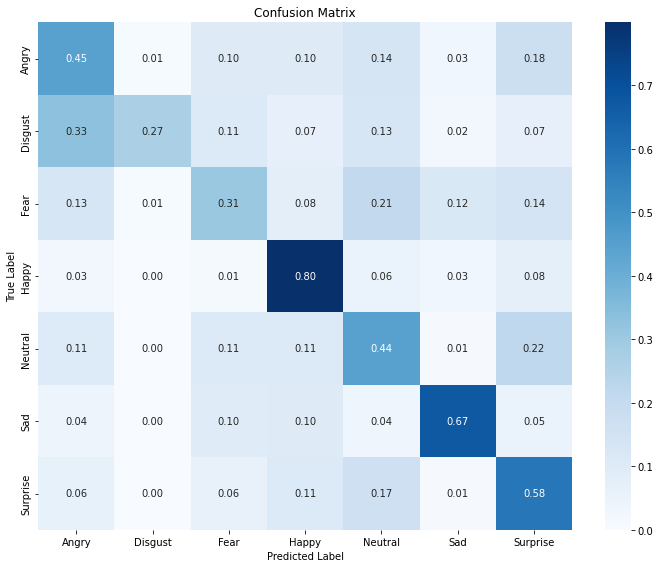

In [5]:
evaluate_model(best_model, test_loader)